In [63]:
# 설치 후, runtime 다시시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (9,166 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/workspace/tacademy/tacademy_dl/DL_mini_project/jobplanet_recsys

/content/drive/MyDrive/workspace/tacademy/tacademy_dl/DL_mini_project/jobplanet_recsys


In [3]:
%ls

comp_info.csv    jobplanet_crawling.ipynb  model_1.model  temp_wv.model
jobplanet_2.csv  jobplanet_recsys.ipynb    temp/
jobplanet_3.csv  jobplanet_reviews.csv     temp_wv


In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

from tqdm import tqdm
import re

from sklearn.metrics.pairwise import cosine_similarity

In [69]:
company_info = pd.read_csv("comp_info.csv", encoding='utf-8')
company_info.head()

,Unnamed: 0,company,avg_score,avg_wage,review_cnt
0,0,(주)티몬,2.8,4453,2214
1,1,(주)위메프,2.6,4228,2178
2,2,(주)엘지유플러스,3.2,5098,1933
3,3,삼성에스디에스(주),3.5,6297,1911
4,4,(주)엘지씨엔에스,3.1,5643,1865


In [70]:
company_info.rename(columns={"Unnamed: 0":"companyId"}, inplace=True)

In [71]:
company_info.head()

,companyId,company,avg_score,avg_wage,review_cnt
0,0,(주)티몬,2.8,4453,2214
1,1,(주)위메프,2.6,4228,2178
2,2,(주)엘지유플러스,3.2,5098,1933
3,3,삼성에스디에스(주),3.5,6297,1911
4,4,(주)엘지씨엔에스,3.1,5643,1865


In [8]:
comp_map = {company_info.iat[i, 1]:company_info.iat[i, 0] for i in range(len(company_info))}

In [9]:
raw_data = pd.read_csv("./jobplanet_reviews.csv", encoding="utf-8", index_col=0)
raw_data.head()

,회사,직무,상황,지역,작성일,총점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,경영진,총평,장점,단점,바라는점
0,(주)티몬,기획/경영,\n 전직원\n,서울,2022. 12,60%,60%,80%,60%,60%,20%,\nBEST\n 젊은 기업이었지만 점점 변하는 느낌을 강하게 받았습니다\n...,연차 자유롭게 사용티몬 카페 있음수평적인 분위기였음,취합 지옥야근할수밖에 없는 업무량제가 있던 팀은 분위기 삭막했습니다,없습니다 직원들이 바라는 점이 있어 들어주었다면 이렇게 추락하지는 않았을겁다
1,(주)티몬,개발,\n 전직원\n,서울,2022. 12,60%,20%,40%,60%,40%,20%,\nBEST\n 인수후 개발자가 본인의 업무에 책임감을 가지고 일힐 수 있...,연차는 눈치 안보고 사용할 수 있으며 인수후에도 자유로운 분위기는 꽤 자유롭다,인수후 업무에 대한 책임을 가지고 할 수 없게끔 일들이 들어온다,책임을 가지고 일을 할 수 있도록 환경을 만들어 주는게 좋을 것 같다 인수후 보여준...
2,(주)티몬,마케팅/시장조사,\n 전직원\n,서울,2022. 12,60%,60%,60%,60%,60%,60%,\nBEST\n 다양한 경험을 할 수 있는것은 좋았으나. 업무량이 다소 많...,교통이 편리합니다. 조직 내 소통이 자유롭고 빠른 피드백을 통해. 업무에 능률이 높...,다소 비효율적인 업무처리 과정이 많은듯합니다. 직원을 생각한 체계를 마련해줬으면 좋...,경영진에 바라는점은 따로 없습니다. 위 단점처럼 체계를 부탁드립니다
3,(주)티몬,개발,\n 전직원\n,기타,2022. 12,60%,60%,60%,60%,60%,60%,\nBEST\n 개발자가 자신의 강점을 보이고 약점을 보완하게끔 장려하는 ...,자기계발을 위한 개발 비용 지원하는 부분이 좋고 업무 분담 체계가 깔끔한 편이고 자...,단순 보고를 위한 문서작업이 많아 비효율적이고 복지제도가 실제 활용할 수 있는 것이...,직원들의 목소리에 귀 기울이고 해결책을 마련해주길 바랍니다 합리적인 보상 체계를 마...
4,(주)티몬,마케팅/시장조사,\n 현직원\n,서울,2022. 12,60%,60%,60%,60%,60%,40%,\nBEST\n 어떤 마음을 가지고 행동하는가에 따라 달라질수 있는 회사\...,각자 개인으로 진행하는 일이 많아서 서로에게 별로 관심이 없지만 친해지고 좋아지면 ...,단순 보고가 많아 잡일이 많음 할게 너무 많고 회의도 많음 지겹도록 일이 많은데 돈...,신규사업에 적극적으로 대응했으면하고 그일에 대하여 전문적인 지식을 가지고 있었으면 합니다


In [10]:
len(raw_data.회사.unique())

150

In [40]:
df = raw_data.copy()

df.상황 = df.상황.apply(lambda x: x.strip())
df.총평 = df.총평.apply(lambda x: x.split('\n')[2].strip())
df.iloc[:, 5:11] = df.iloc[:, 5:11].applymap(lambda x: int(x[:-1]))
df.head()

,회사,직무,상황,지역,작성일,총점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,경영진,총평,장점,단점,바라는점
0,(주)티몬,기획/경영,전직원,서울,2022. 12,60,60,80,60,60,20,젊은 기업이었지만 점점 변하는 느낌을 강하게 받았습니다,연차 자유롭게 사용티몬 카페 있음수평적인 분위기였음,취합 지옥야근할수밖에 없는 업무량제가 있던 팀은 분위기 삭막했습니다,없습니다 직원들이 바라는 점이 있어 들어주었다면 이렇게 추락하지는 않았을겁다
1,(주)티몬,개발,전직원,서울,2022. 12,60,20,40,60,40,20,인수후 개발자가 본인의 업무에 책임감을 가지고 일힐 수 있을지 의문,연차는 눈치 안보고 사용할 수 있으며 인수후에도 자유로운 분위기는 꽤 자유롭다,인수후 업무에 대한 책임을 가지고 할 수 없게끔 일들이 들어온다,책임을 가지고 일을 할 수 있도록 환경을 만들어 주는게 좋을 것 같다 인수후 보여준...
2,(주)티몬,마케팅/시장조사,전직원,서울,2022. 12,60,60,60,60,60,60,다양한 경험을 할 수 있는것은 좋았으나. 업무량이 다소 많음,교통이 편리합니다. 조직 내 소통이 자유롭고 빠른 피드백을 통해. 업무에 능률이 높...,다소 비효율적인 업무처리 과정이 많은듯합니다. 직원을 생각한 체계를 마련해줬으면 좋...,경영진에 바라는점은 따로 없습니다. 위 단점처럼 체계를 부탁드립니다
3,(주)티몬,개발,전직원,기타,2022. 12,60,60,60,60,60,60,개발자가 자신의 강점을 보이고 약점을 보완하게끔 장려하는 곳으로 다양한 개발환경을 ...,자기계발을 위한 개발 비용 지원하는 부분이 좋고 업무 분담 체계가 깔끔한 편이고 자...,단순 보고를 위한 문서작업이 많아 비효율적이고 복지제도가 실제 활용할 수 있는 것이...,직원들의 목소리에 귀 기울이고 해결책을 마련해주길 바랍니다 합리적인 보상 체계를 마...
4,(주)티몬,마케팅/시장조사,현직원,서울,2022. 12,60,60,60,60,60,40,어떤 마음을 가지고 행동하는가에 따라 달라질수 있는 회사,각자 개인으로 진행하는 일이 많아서 서로에게 별로 관심이 없지만 친해지고 좋아지면 ...,단순 보고가 많아 잡일이 많음 할게 너무 많고 회의도 많음 지겹도록 일이 많은데 돈...,신규사업에 적극적으로 대응했으면하고 그일에 대하여 전문적인 지식을 가지고 있었으면 합니다


In [41]:
df["companyId"] = df["회사"].apply(lambda x: comp_map[x])

In [42]:
df = pd.concat([df.iloc[:, -1], df.iloc[:,:-1]], axis=1)

In [43]:
df.head()

,companyId,회사,직무,상황,지역,작성일,총점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,경영진,총평,장점,단점,바라는점
0,0,(주)티몬,기획/경영,전직원,서울,2022. 12,60,60,80,60,60,20,젊은 기업이었지만 점점 변하는 느낌을 강하게 받았습니다,연차 자유롭게 사용티몬 카페 있음수평적인 분위기였음,취합 지옥야근할수밖에 없는 업무량제가 있던 팀은 분위기 삭막했습니다,없습니다 직원들이 바라는 점이 있어 들어주었다면 이렇게 추락하지는 않았을겁다
1,0,(주)티몬,개발,전직원,서울,2022. 12,60,20,40,60,40,20,인수후 개발자가 본인의 업무에 책임감을 가지고 일힐 수 있을지 의문,연차는 눈치 안보고 사용할 수 있으며 인수후에도 자유로운 분위기는 꽤 자유롭다,인수후 업무에 대한 책임을 가지고 할 수 없게끔 일들이 들어온다,책임을 가지고 일을 할 수 있도록 환경을 만들어 주는게 좋을 것 같다 인수후 보여준...
2,0,(주)티몬,마케팅/시장조사,전직원,서울,2022. 12,60,60,60,60,60,60,다양한 경험을 할 수 있는것은 좋았으나. 업무량이 다소 많음,교통이 편리합니다. 조직 내 소통이 자유롭고 빠른 피드백을 통해. 업무에 능률이 높...,다소 비효율적인 업무처리 과정이 많은듯합니다. 직원을 생각한 체계를 마련해줬으면 좋...,경영진에 바라는점은 따로 없습니다. 위 단점처럼 체계를 부탁드립니다
3,0,(주)티몬,개발,전직원,기타,2022. 12,60,60,60,60,60,60,개발자가 자신의 강점을 보이고 약점을 보완하게끔 장려하는 곳으로 다양한 개발환경을 ...,자기계발을 위한 개발 비용 지원하는 부분이 좋고 업무 분담 체계가 깔끔한 편이고 자...,단순 보고를 위한 문서작업이 많아 비효율적이고 복지제도가 실제 활용할 수 있는 것이...,직원들의 목소리에 귀 기울이고 해결책을 마련해주길 바랍니다 합리적인 보상 체계를 마...
4,0,(주)티몬,마케팅/시장조사,현직원,서울,2022. 12,60,60,60,60,60,40,어떤 마음을 가지고 행동하는가에 따라 달라질수 있는 회사,각자 개인으로 진행하는 일이 많아서 서로에게 별로 관심이 없지만 친해지고 좋아지면 ...,단순 보고가 많아 잡일이 많음 할게 너무 많고 회의도 많음 지겹도록 일이 많은데 돈...,신규사업에 적극적으로 대응했으면하고 그일에 대하여 전문적인 지식을 가지고 있었으면 합니다


In [15]:
!pip install gensim==4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import RegexpTokenizer
from konlpy.tag import Okt

import gensim
from gensim.models.word2vec import Word2Vec

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [18]:
df.총평 = df.총평.apply(lambda x: x+' ')

In [19]:
temp_sentence = df[["회사", "총평"]].groupby("회사").sum()
temp_sentence

,총평
회사,
(주)골프존,쉬어가기 너무 좋은 회사 적당히 놀고 적당히 일하며 적당히 월급받기는 좋음 체계적인...
(주)네오위즈,돈을 많이 버는 팀은 대우가 매우 좋은 회사팀바팀이 심한 회사 팀마다 분위기가 다르...
(주)넥슨코리아,게임업계의 최고의 대우와 처우지만 IT업계로 확장하면 조금 별로인 회사 즐거운 분위...
(주)다우기술,사회생활 첫 스타트 끊기 좋았던 곳으로 기억 회사생활 전반을 배울 수 있었음 회사 ...
(주)더존비즈온,개발자가 무난하게 다닐 수 있는곳ERP에대해 경험하기 좋은 곳 부산 한정 신입들의 ...
...,...
한전케이디엔(주),안정적인 직장 공공기관 중에서 급여 복지가 나쁘지 않은편최근 들어 젊은직원들이 많아...
현대엠엔소프트(주),좋은 회사 좋은 사람들 나쁘지않은 연봉 잘갖춰진 시스템 서울에서 연구개발할 수 있는...
현대오토에버(주),사람 바이 사람 업무 강도가 너무 다릅니다 팀바이팀도 포함 급여만 올려주면 대만족은...


In [20]:
tokenizer = RegexpTokenizer('\w+')
tokens = temp_sentence.총평.apply(tokenizer.tokenize)
tokens

회사
(주)골프존        [쉬어가기, 너무, 좋은, 회사, 적당히, 놀고, 적당히, 일하며, 적당히, 월급받...
(주)네오위즈       [돈을, 많이, 버는, 팀은, 대우가, 매우, 좋은, 회사팀바팀이, 심한, 회사, ...
(주)넥슨코리아      [게임업계의, 최고의, 대우와, 처우지만, IT업계로, 확장하면, 조금, 별로인, ...
(주)다우기술       [사회생활, 첫, 스타트, 끊기, 좋았던, 곳으로, 기억, 회사생활, 전반을, 배울...
(주)더존비즈온      [개발자가, 무난하게, 다닐, 수, 있는곳ERP에대해, 경험하기, 좋은, 곳, 부산...
                                    ...                        
한전케이디엔(주)     [안정적인, 직장, 공공기관, 중에서, 급여, 복지가, 나쁘지, 않은편최근, 들어,...
현대엠엔소프트(주)    [좋은, 회사, 좋은, 사람들, 나쁘지않은, 연봉, 잘갖춰진, 시스템, 서울에서, ...
현대오토에버(주)     [사람, 바이, 사람, 업무, 강도가, 너무, 다릅니다, 팀바이팀도, 포함, 급여만...
효성아이티엑스(주)    [콜센터등, 파견많이함, 사람자주바뀌고, 대기업복지는, 적용되서, 괜찮름, 콜센터,...
휴넷(주)         [일에, 대한, 욕심이, 있다면, 충분히, 채울, 수, 있는, 곳, 다만, 너무, ...
Name: 총평, Length: 150, dtype: object

In [21]:
model = Word2Vec(tokens, min_count=2)

In [22]:
model

In [23]:
model.build_vocab(tokens)
model.train(tokens, total_examples = model.corpus_count, epochs = 15)

(1756222, 2343420)

In [24]:
def get_document_vectors(tokens):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in tqdm(tokens):
        doc2vec = None
        count = 0
        for word in line:
            if word in model.wv.key_to_index:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = model.wv[word]
                else:
                    doc2vec = doc2vec + model.wv[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [25]:
document_embedding_list = get_document_vectors(tokens)
len(document_embedding_list)

100%|██████████| 150/150 [00:00<00:00, 400.19it/s]


150

In [26]:
model.save('model_1.model')

In [27]:
model = Word2Vec.load("model_1.model")

In [28]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (150, 150)


In [29]:
df_sim = pd.DataFrame(cosine_similarities, index=temp_sentence.index, columns=temp_sentence.index )
df_sim

회사,(주)골프존,(주)네오위즈,(주)넥슨코리아,(주)다우기술,(주)더존비즈온,(주)드림어스컴퍼니,(주)디비아이엔씨,(주)디지털다임,(주)롯데닷컴,(주)링크프라이스,...,한국마이크로소프트(유),한국아이비엠(주),한국아이비엠테크니컬솔루션(유),한국오라클(유),한국지능정보사회진흥원,한전케이디엔(주),현대엠엔소프트(주),현대오토에버(주),효성아이티엑스(주),휴넷(주)
회사,,,,,,,,,,,,,,,,,,,,,
(주)골프존,1.000000,0.997657,0.998348,0.997879,0.990280,0.986727,0.987862,0.992419,0.994956,0.987906,...,0.982060,0.982730,0.989159,0.996691,0.985812,0.994542,0.991934,0.989743,0.989973,0.995980
(주)네오위즈,0.997657,1.000000,0.995797,0.998141,0.994024,0.988316,0.986769,0.996566,0.997094,0.993114,...,0.989054,0.988457,0.994317,0.997699,0.992074,0.997435,0.991865,0.982620,0.991790,0.997084
(주)넥슨코리아,0.998348,0.995797,1.000000,0.997734,0.984961,0.979438,0.982708,0.988869,0.991607,0.982441,...,0.978791,0.977683,0.985963,0.993798,0.980962,0.992402,0.987932,0.990201,0.985852,0.992114
(주)다우기술,0.997879,0.998141,0.997734,1.000000,0.990813,0.983329,0.982163,0.995193,0.994191,0.989760,...,0.987122,0.986372,0.993644,0.996556,0.988794,0.997279,0.987997,0.983611,0.988155,0.994204
(주)더존비즈온,0.990280,0.994024,0.984961,0.990813,1.000000,0.996947,0.991632,0.995359,0.996165,0.998674,...,0.986111,0.992445,0.993488,0.993774,0.993667,0.993001,0.993155,0.975570,0.996980,0.996080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
한전케이디엔(주),0.994542,0.997435,0.992402,0.997279,0.993001,0.985218,0.981082,0.996514,0.996234,0.993800,...,0.990443,0.990023,0.995740,0.995908,0.994268,1.000000,0.986197,0.976138,0.989113,0.993726
현대엠엔소프트(주),0.991934,0.991865,0.987932,0.987997,0.993155,0.995677,0.998163,0.984769,0.995504,0.989707,...,0.973923,0.980179,0.982606,0.991774,0.982281,0.986197,1.000000,0.990776,0.995496,0.995926
현대오토에버(주),0.989743,0.982620,0.990201,0.983611,0.975570,0.979148,0.989487,0.969016,0.984307,0.969696,...,0.953500,0.958022,0.964691,0.982336,0.961475,0.976138,0.990776,1.000000,0.983599,0.984554


In [86]:
def recommendations(company, k):
    print(company_info[company_info.company == company][["company", "avg_score", "avg_wage"]])
    
    result = df_sim[company].sort_values(ascending=False)[1:k+1].index.values.tolist()

    temp = pd.DataFrame()
    for comp in result:
        temp = pd.concat([temp, company_info[company_info.company == comp][["company", "avg_score", "avg_wage"]]])

    return temp.reset_index(drop=True)

recommendations("(주)네오위즈", 10)

    company  avg_score  avg_wage
61  (주)네오위즈        3.3      4511


,company,avg_score,avg_wage
0,엔에이치엔(주),3.4,5252
1,(주)연합뉴스,3.4,5375
2,씨제이올리브네트웍스(주),2.9,5040
3,(주)파수,3.1,4532
4,(주)알티캐스트,3.3,4434
5,다날(주),3.0,4209
6,에스케이브로드밴드(주),3.4,5543
7,(주)엔씨소프트,3.6,5723
8,(주)다우기술,3.4,4905
9,(주)엘지유플러스,3.2,5098


In [80]:
company_info[company_info.company == "다날(주)"][["company", "avg_score", "avg_wage"]]

,company,avg_score,avg_wage
134,다날(주),3.0,4209


In [72]:
company_info.company == ""

,companyId,company,avg_score,avg_wage,review_cnt
0,0,(주)티몬,2.8,4453,2214
1,1,(주)위메프,2.6,4228,2178
2,2,(주)엘지유플러스,3.2,5098,1933
3,3,삼성에스디에스(주),3.5,6297,1911
4,4,(주)엘지씨엔에스,3.1,5643,1865
...,...,...,...,...,...
476,476,(주)삼보컴퓨터,2.8,3567,101
477,477,(주)코스콤,3.7,7560,101
478,478,(주)트윔,2.7,3920,101
479,479,매드업(주),3.4,3800,101


In [31]:
from sklearn.manifold import TSNE

In [32]:
vocab = model.wv.key_to_index

In [33]:
X = model.wv[vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X[:100])

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [34]:
vv =sorted(vocab, key=vocab.get)

In [35]:
df = pd.DataFrame(X_tsne, index=vv[:100], columns=['x','y'])
df

,x,y
회사,-3.807805,6.264286
수,-2.183492,-1.191673
있는,-4.524563,1.673489
좋은,5.187304,2.849935
곳,-3.964094,5.625808
...,...,...
편,2.628607,7.908405
비해,1.602382,8.418117
같은,0.002246,7.204806
워라밸은,2.789885,6.900387


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


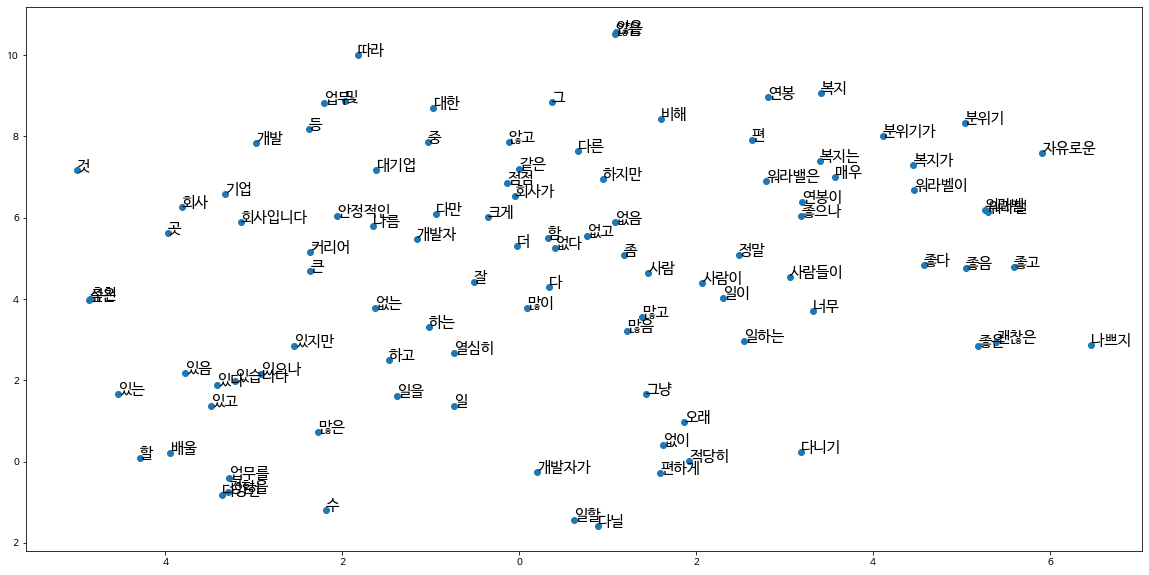

In [36]:
fig = plt.figure()
fig.set_size_inches(20, 10)
ax = fig.add_subplot(1,1,1)
ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=15)
plt.show()